In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# to split the datasets
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# for one hot encoding with sklearn
from sklearn.preprocessing import OneHotEncoder

# for one hot encoding with feature-engine
from feature_engine.categorical_encoders import OneHotCategoricalEncoder

### OneHot Encoding
--------------------------------
Just like imputation, all methods of categorical encoding should be performed over the training set, and then propagated to the test set. 

Why? 

Because these methods will "learn" patterns from the train data, and therefore you want to avoid leaking information and overfitting. But more importantly, because we don't know whether in future / live data, we will have all the categories present in the train data, or if there will be more or less categories. Therefore, we want to anticipate this uncertainty by setting the right processes right from the start. We want to create transformers that learn the categories from the train set, and used those learned categories to create the dummy variables in both train and test sets.


In [3]:
# load dataset
data = pd.read_csv('data/titanic.csv',
                   usecols=['sex', 'embarked', 'cabin', 'survived'])
data.head()

,survived,sex,cabin,embarked
0,0,male,NaN,S
1,1,female,C85,C
2,1,female,NaN,S
3,1,female,C123,S
4,0,male,NaN,S


In [4]:
# let's capture only the first letter of the 
# cabin for this demonstration

data['cabin'] = data['cabin'].str[0]

data.head()

,survived,sex,cabin,embarked
0,0,male,NaN,S
1,1,female,C,C
2,1,female,NaN,S
3,1,female,C,S
4,0,male,NaN,S


In [29]:
# let's separate into training and testing set

x_train, x_test, y_train, y_test = train_test_split(
    data[['sex', 'embarked', 'cabin']],  # predictors
    data['survived'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

x_train.shape, x_test.shape

((623, 3), (268, 3))

In [6]:
x_train.dtypes

sex         object
embarked    object
cabin       object
dtype: object

In [8]:
# exploring cardinality
# sex
x_train['sex'].unique(), x_train['embarked'].unique(), x_train['cabin'].unique()

(array(['male', 'female'], dtype=object),
 array(['S', 'C', 'Q', nan], dtype=object),
 array(['E', 'D', nan, 'B', 'C', 'A', 'F', 'G', 'T'], dtype=object))

In [9]:
## into k dummy variables
tmp = pd.get_dummies(x_train["sex"])
tmp.head()

,female,male
857,0,1
52,1,0
386,0,1
124,0,1
578,1,0


In [10]:
# for better visualisation let's put the dummies next
# to the original variable

pd.concat([x_train['sex'],
           pd.get_dummies(x_train['sex'])], axis=1).head()

,sex,female,male
857,male,0,1
52,female,1,0
386,male,0,1
124,male,0,1
578,female,1,0


In [11]:
# let's get encodings for all categoricals
tmp = pd.get_dummies(x_train)
tmp.head()

,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,cabin_A,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_G,cabin_T
857,0,1,0,0,1,0,0,0,0,1,0,0,0
52,1,0,1,0,0,0,0,0,1,0,0,0,0
386,0,1,0,0,1,0,0,0,0,0,0,0,0
124,0,1,0,0,1,0,0,0,1,0,0,0,0
578,1,0,1,0,0,0,0,0,0,0,0,0,0


In [12]:
tmp = pd.get_dummies(x_test)
tmp.head()

## notice the change in the dimension size for test?

,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,cabin_A,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_G
495,0,1,1,0,0,0,0,0,0,0,0,0
648,0,1,0,0,1,0,0,0,0,0,0,0
278,0,1,0,1,0,0,0,0,0,0,0,0
31,1,0,1,0,0,0,1,0,0,0,0,0
255,1,0,1,0,0,0,0,0,0,0,0,0


In [13]:
## let's try to encode into k-1 categories

tmp = pd.get_dummies(x_train, drop_first=True)
tmp.head()

,sex_male,embarked_Q,embarked_S,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_G,cabin_T
857,1,0,1,0,0,0,1,0,0,0
52,0,0,0,0,0,1,0,0,0,0
386,1,0,1,0,0,0,0,0,0,0
124,1,0,1,0,0,1,0,0,0,0
578,0,0,0,0,0,0,0,0,0,0


In [14]:
### get_dummies() can also handle missing values
tmp = pd.get_dummies(x_train, drop_first=True, dummy_na=True)
tmp.head()

,sex_male,sex_nan,embarked_Q,embarked_S,embarked_nan,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_G,cabin_T,cabin_nan
857,1,0,0,1,0,0,0,0,1,0,0,0,0
52,0,0,0,0,0,0,0,1,0,0,0,0,0
386,1,0,0,1,0,0,0,0,0,0,0,0,1
124,1,0,0,1,0,0,0,1,0,0,0,0,0
578,0,0,0,0,0,0,0,0,0,0,0,0,1


#### OneHotEncoding - scikit-learn

<b>Advantages:</b>

- Fast
- Creates the same number of features in train and test set

<b>Limitations:</b>

- it returns a numpy array instead of a pandas dataframe
- it does not return the variable names, therefore inconvenient for variable exploration

In [15]:
# create the encoder and fit to train
encoder = OneHotEncoder(
    categories="auto",
    drop="first", # this returns k-1 categories
    sparse=False,
    handle_unknown="error" # this makes sure rare labels are encoded
)
encoder.fit(x_train.fillna("MISSING"))

OneHotEncoder(drop='first', sparse=False)

In [16]:
encoder.categories_

[array(['female', 'male'], dtype=object),
 array(['C', 'MISSING', 'Q', 'S'], dtype=object),
 array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'MISSING', 'T'], dtype=object)]

In [17]:
# transform
tmp = encoder.transform(x_train.fillna("MISSING"))
# this retuns a numpy array 
pd.DataFrame(tmp).head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [18]:
# we can get the column names by 
encoder.get_feature_names()

array(['x0_male', 'x1_MISSING', 'x1_Q', 'x1_S', 'x2_B', 'x2_C', 'x2_D',
       'x2_E', 'x2_F', 'x2_G', 'x2_MISSING', 'x2_T'], dtype=object)

In [19]:
## let's construct the test set by doing the same
tmp = encoder.transform(x_test.fillna("MISSING"))
tmp = pd.DataFrame(tmp, columns=encoder.get_feature_names())
tmp.head()

,x0_male,x1_MISSING,x1_Q,x1_S,x2_B,x2_C,x2_D,x2_E,x2_F,x2_G,x2_MISSING,x2_T
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


#### OneHotEncoding - feature_engine

<b>Advantages:</b>

- Fast
- Returns a DataFrame 
- Returns feature names
- Allows selective feature encoding

<b>Limitations:</b>
- N/A

In [20]:
encoder = OneHotCategoricalEncoder(
    top_categories=None,
    variables=["sex", "embarked"], # selective feature encoding
    drop_last=True, # ensures k-1 encoding
)
encoder.fit(x_train.fillna("MISSING"))


OneHotCategoricalEncoder(drop_last=True, variables=['sex', 'embarked'])

In [21]:
encoder.encoder_dict_

{'sex': ['male'], 'embarked': ['S', 'C', 'Q']}

In [22]:
tmp = encoder.transform(x_train.fillna("MISSING"))
tmp.head()

,cabin,sex_male,embarked_S,embarked_C,embarked_Q
857,E,1,1,0,0
52,D,0,0,1,0
386,MISSING,1,1,0,0
124,D,1,1,0,0
578,MISSING,0,0,1,0


In [23]:
tmp = encoder.transform(x_test.fillna("MISSING"))
tmp.head()

,cabin,sex_male,embarked_S,embarked_C,embarked_Q
495,MISSING,1,0,1,0
648,MISSING,1,1,0,0
278,MISSING,1,0,0,1
31,B,0,0,1,0
255,MISSING,0,0,1,0


----------------------------
See how feature engine automatically selected all categorical variables eventhough we didnt specify cabin

In [37]:
encoder = OneHotCategoricalEncoder(
    top_categories=None,
    drop_last=True, # ensures k-1 encoding
)
encoder.fit(x_train.fillna("MISSING"))


OneHotCategoricalEncoder(drop_last=True, variables=['sex', 'embarked', 'cabin'])

In [38]:
tmp = encoder.transform(x_train.fillna("MISSING"))
tmp.head()

,sex_male,embarked_S,embarked_C,embarked_Q,cabin_E,cabin_D,cabin_MISSING,cabin_B,cabin_C,cabin_A,cabin_F,cabin_G
857,1,1,0,0,1,0,0,0,0,0,0,0
52,0,0,1,0,0,1,0,0,0,0,0,0
386,1,1,0,0,0,0,1,0,0,0,0,0
124,1,1,0,0,0,1,0,0,0,0,0,0
578,0,0,1,0,0,0,1,0,0,0,0,0


In [39]:
tmp = encoder.transform(x_test.fillna("MISSING"))
tmp.head()

,sex_male,embarked_S,embarked_C,embarked_Q,cabin_E,cabin_D,cabin_MISSING,cabin_B,cabin_C,cabin_A,cabin_F,cabin_G
495,1,0,1,0,0,0,1,0,0,0,0,0
648,1,1,0,0,0,0,1,0,0,0,0,0
278,1,0,0,1,0,0,1,0,0,0,0,0
31,0,0,1,0,0,0,0,1,0,0,0,0
255,0,0,1,0,0,0,1,0,0,0,0,0


In [41]:
x_train["cabin"].unique()

array(['E', 'D', nan, 'B', 'C', 'A', 'F', 'G', 'T'], dtype=object)

### OneHotEncoding Top Features

In [62]:
# load dataset
data = pd.read_csv(
    'data/housing.csv',
    usecols=['Neighborhood', 'Exterior1st', 'Exterior2nd', 'SalePrice']
)
print(data.shape)

(1460, 4)


In [4]:
# lets take a look at cardinality of each feature
[print(f"{col} : {len(data[col].unique())} labels") for col in data.columns]

Neighborhood : 25 labels
Exterior1st : 15 labels
Exterior2nd : 16 labels
SalePrice : 663 labels


[None, None, None, None]

In [5]:
# split into train and test
x_train, x_test, y_train, y_test = train_test_split(
    data[['Neighborhood', 'Exterior1st', 'Exterior2nd']],  # predictors
    data['SalePrice'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

x_train.shape, x_test.shape

((1022, 3), (438, 3))

In [6]:
pd.get_dummies(x_train, drop_first=True).shape

(1022, 53)

#### OneHotEncoding with Pandas and Numpy

In [7]:
x_train["Neighborhood"].value_counts().sort_values(ascending=False).head(10)

NAmes      151
CollgCr    105
OldTown     73
Edwards     71
Sawyer      61
Somerst     56
Gilbert     55
NWAmes      51
NridgHt     51
SawyerW     45
Name: Neighborhood, dtype: int64

In [8]:
# make a list of top 10 categories
top_10 = [x for x in x_train["Neighborhood"].value_counts().sort_values(ascending=False).head(10).index]
top_10

['NAmes',
 'CollgCr',
 'OldTown',
 'Edwards',
 'Sawyer',
 'Somerst',
 'Gilbert',
 'NWAmes',
 'NridgHt',
 'SawyerW']

In [9]:
# lets encode the variables andassign them encoded values
for label in top_10:
    # train
    x_train[f"Neighborhood_{label}"] = np.where(x_train["Neighborhood"] == label, 1, 0)
    # test
    x_test[f"Neighborhood_{label}"] = np.where(x_test["Neighborhood"] == label, 1, 0)

x_train.shape, x_test.shape

((1022, 13), (438, 13))

In [10]:
# let's take a look inside
x_train[["Neighborhood"] + [f"Neighborhood_{c}" for c in top_10]].head()

,Neighborhood,Neighborhood_NAmes,Neighborhood_CollgCr,Neighborhood_OldTown,Neighborhood_Edwards,Neighborhood_Sawyer,Neighborhood_Somerst,Neighborhood_Gilbert,Neighborhood_NWAmes,Neighborhood_NridgHt,Neighborhood_SawyerW
64,CollgCr,0,1,0,0,0,0,0,0,0,0
682,ClearCr,0,0,0,0,0,0,0,0,0,0
960,BrkSide,0,0,0,0,0,0,0,0,0,0
1384,Edwards,0,0,0,1,0,0,0,0,0,0
1100,SWISU,0,0,0,0,0,0,0,0,0,0


In [11]:
# lets functionalize the above
def get_top_n(df, feature, n):
    return [
        x for x in df[feature].value_counts().sort_values(
            ascending=False).head(n).index
    ]

def encode(train, test, feature, top_n_labels):
    for label in top_n_labels:
        # train
        x_train[f"{feature}_{label}"] = np.where(x_train[feature] == label, 1, 0)
        # test
        x_test[f"{feature}_{label}"] = np.where(x_test[feature] == label, 1, 0)
    return train, test

In [12]:
# loop throuh few features and apply the same
for feature in ["Exterior1st", "Exterior2nd"]:
    top_n = get_top_n(x_train, feature, n=10)
    x_train, x_test = encode(x_train, x_test, feature, top_n)


In [13]:
x_train.head()

,Neighborhood,Exterior1st,Exterior2nd,Neighborhood_NAmes,Neighborhood_CollgCr,Neighborhood_OldTown,Neighborhood_Edwards,Neighborhood_Sawyer,Neighborhood_Somerst,Neighborhood_Gilbert,...,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_HdBoard,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_CmentBd,Exterior2nd_Wd Shng,Exterior2nd_BrkFace,Exterior2nd_AsbShng,Exterior2nd_Stucco
64,CollgCr,VinylSd,VinylSd,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
682,ClearCr,Wd Sdng,Wd Sdng,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
960,BrkSide,Wd Sdng,Plywood,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1384,Edwards,WdShing,Wd Shng,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1100,SWISU,Wd Sdng,Wd Sdng,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


#### OneHotEncoding with Feature Engine

In [14]:
# split into train and test
x_train, x_test, y_train, y_test = train_test_split(
    data[['Neighborhood', 'Exterior1st', 'Exterior2nd']],  # predictors
    data['SalePrice'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

x_train.shape, x_test.shape

((1022, 3), (438, 3))

In [15]:
encoder = OneHotCategoricalEncoder(
    top_categories=10, # this is where we specify the top_n categories
    variables=['Neighborhood', 'Exterior1st', 'Exterior2nd'],
    drop_last=True, # k-1 encoding
)
encoder.fit(x_train)

OneHotCategoricalEncoder(drop_last=True, top_categories=10,
                         variables=['Neighborhood', 'Exterior1st',
                                    'Exterior2nd'])

In [16]:
encoder.encoder_dict_

{'Neighborhood': ['NAmes',
  'CollgCr',
  'OldTown',
  'Edwards',
  'Sawyer',
  'Somerst',
  'Gilbert',
  'NWAmes',
  'NridgHt',
  'SawyerW'],
 'Exterior1st': ['VinylSd',
  'HdBoard',
  'Wd Sdng',
  'MetalSd',
  'Plywood',
  'CemntBd',
  'BrkFace',
  'WdShing',
  'Stucco',
  'AsbShng'],
 'Exterior2nd': ['VinylSd',
  'Wd Sdng',
  'HdBoard',
  'MetalSd',
  'Plywood',
  'CmentBd',
  'Wd Shng',
  'BrkFace',
  'AsbShng',
  'Stucco']}

In [17]:
# now apply transform
x_train = encoder.transform(x_train)
x_test = encoder.transform(x_test)

x_train.head()

,Neighborhood_NAmes,Neighborhood_CollgCr,Neighborhood_OldTown,Neighborhood_Edwards,Neighborhood_Sawyer,Neighborhood_Somerst,Neighborhood_Gilbert,Neighborhood_NWAmes,Neighborhood_NridgHt,Neighborhood_SawyerW,...,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_HdBoard,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_CmentBd,Exterior2nd_Wd Shng,Exterior2nd_BrkFace,Exterior2nd_AsbShng,Exterior2nd_Stucco
64,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
682,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
960,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1384,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1100,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


### Ordinal/Integer Encoding

In [33]:
# for integer encoding using sklearn
from sklearn.preprocessing import LabelEncoder

# for integer encoding using feature-engine
from feature_engine.categorical_encoders import OrdinalCategoricalEncoder

In [26]:
# load dataset
data = pd.read_csv(
    'data/housing.csv',
    usecols=['Neighborhood', 'Exterior1st', 'Exterior2nd', 'SalePrice']
)
print(data.shape)
# split into train and test
x_train, x_test, y_train, y_test = train_test_split(
    data[['Neighborhood', 'Exterior1st', 'Exterior2nd']],  # predictors
    data['SalePrice'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

x_train.shape, x_test.shape

(1460, 4)


((1022, 3), (438, 3))

#### Ordinal Encoding with pandas


<b> Advantages: </b>
- fast
- returns pandas dataframe

<b> Limitations of pandas:</b>
- it does not preserve information from train data to propagate to test data

In [27]:
# lets creat a mapping dictionary for all the features
_mapping = {
    k:v 
    for v, k in enumerate(x_train["Neighborhood"].unique(), 0) # range from 0 to n-1
}
_mapping

{'CollgCr': 0,
 'ClearCr': 1,
 'BrkSide': 2,
 'Edwards': 3,
 'SWISU': 4,
 'Sawyer': 5,
 'Crawfor': 6,
 'NAmes': 7,
 'Mitchel': 8,
 'Timber': 9,
 'Gilbert': 10,
 'Somerst': 11,
 'MeadowV': 12,
 'OldTown': 13,
 'BrDale': 14,
 'NWAmes': 15,
 'NridgHt': 16,
 'SawyerW': 17,
 'NoRidge': 18,
 'IDOTRR': 19,
 'NPkVill': 20,
 'StoneBr': 21,
 'Blmngtn': 22,
 'Veenker': 23,
 'Blueste': 24}

In [28]:
# simply repalce the mapping 
x_train["Neighborhood"] = x_train["Neighborhood"].map(_mapping)
x_test["Neighborhood"] = x_train["Neighborhood"].map(_mapping)
x_train["Neighborhood"].head()

64      0
682     1
960     2
1384    3
1100    4
Name: Neighborhood, dtype: int64

In [29]:
# functionalizing above steps
def map_feature(df, feature):
    return { k:v for v, k in enumerate(df[feature].unique(), 0)}

def ordinal_encode(df, feature, mapping):
    df[feature] = df[feature].map(mapping)
    return df

In [30]:
for feature in ['Exterior1st', 'Exterior2nd']:
    mapping = map_feature(x_train, feature)
    # encode train, test
    x_train = ordinal_encode(x_train, feature, mapping)
    x_test = ordinal_encode(x_test, feature, mapping)
    

In [31]:
x_train.head()

,Neighborhood,Exterior1st,Exterior2nd
64,0,0,0
682,1,1,1
960,2,1,2
1384,3,2,3
1100,4,1,1


#### Ordinal Encoding with sklearn

In [98]:
# split into train and test
x_train, x_test, y_train, y_test = train_test_split(
    data[['Neighborhood', 'Exterior1st', 'Exterior2nd']],  # predictors
    data['SalePrice'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

x_train.shape, x_test.shape

((1022, 3), (438, 3))

In [34]:
# label encoder works only with one variable at a time
label_encoder = LabelEncoder()
label_encoder.fit(x_train["Neighborhood"])

LabelEncoder()

In [35]:
label_encoder.classes_

array(['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr',
       'Crawfor', 'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel',
       'NAmes', 'NPkVill', 'NWAmes', 'NoRidge', 'NridgHt', 'OldTown',
       'SWISU', 'Sawyer', 'SawyerW', 'Somerst', 'StoneBr', 'Timber',
       'Veenker'], dtype=object)

In [36]:
x_train["Neighborhood"] = label_encoder.transform(x_train["Neighborhood"])
x_test["Neighborhood"] = label_encoder.transform(x_test["Neighborhood"])
x_train.head()

,Neighborhood,Exterior1st,Exterior2nd
64,5,VinylSd,VinylSd
682,4,Wd Sdng,Wd Sdng
960,3,Wd Sdng,Plywood
1384,7,WdShing,Wd Shng
1100,18,Wd Sdng,Wd Sdng


 - https://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn
 - http://zacstewart.com/2014/08/05/pipelines-of-featureunions-of-pipelines.html

In [88]:
from collections import defaultdict

In [89]:
# for encoding the varaibles 
d = defaultdict(LabelEncoder)
# train
train_x = x_train.apply(lambda x: d[x.name].fit_transform(x))
# test
test_x = x_test.apply(lambda x: d[x.name].fit_transform(x))


In [90]:
train_x.head()

,Neighborhood,Exterior1st,Exterior2nd
372,20,9,10
142,12,3,14
28,12,8,8
1333,9,13,14
877,16,12,13


In [97]:
# for inverse transforming
train_x_inv = train_x.apply(lambda x: d[x.name].inverse_transform(x))
train_x_inv.head()

#### Ordinal Encoding with feature engine

In [99]:
# split into train and test
x_train, x_test, y_train, y_test = train_test_split(
    data[['Neighborhood', 'Exterior1st', 'Exterior2nd']],  # predictors
    data['SalePrice'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

x_train.shape, x_test.shape

((1022, 3), (438, 3))

In [101]:
ordinal_encoder = OrdinalCategoricalEncoder(
    encoding_method="arbitrary",
    variables=['Neighborhood', 'Exterior1st', 'Exterior2nd']
)
ordinal_encoder.fit(x_train)

OrdinalCategoricalEncoder(encoding_method='arbitrary',
                          variables=['Neighborhood', 'Exterior1st',
                                     'Exterior2nd'])

In [102]:
ordinal_encoder.encoder_dict_

{'Neighborhood': {'CollgCr': 0,
  'ClearCr': 1,
  'BrkSide': 2,
  'Edwards': 3,
  'SWISU': 4,
  'Sawyer': 5,
  'Crawfor': 6,
  'NAmes': 7,
  'Mitchel': 8,
  'Timber': 9,
  'Gilbert': 10,
  'Somerst': 11,
  'MeadowV': 12,
  'OldTown': 13,
  'BrDale': 14,
  'NWAmes': 15,
  'NridgHt': 16,
  'SawyerW': 17,
  'NoRidge': 18,
  'IDOTRR': 19,
  'NPkVill': 20,
  'StoneBr': 21,
  'Blmngtn': 22,
  'Veenker': 23,
  'Blueste': 24},
 'Exterior1st': {'VinylSd': 0,
  'Wd Sdng': 1,
  'WdShing': 2,
  'HdBoard': 3,
  'MetalSd': 4,
  'AsphShn': 5,
  'BrkFace': 6,
  'Plywood': 7,
  'CemntBd': 8,
  'Stucco': 9,
  'BrkComm': 10,
  'AsbShng': 11,
  'ImStucc': 12,
  'CBlock': 13,
  'Stone': 14},
 'Exterior2nd': {'VinylSd': 0,
  'Wd Sdng': 1,
  'Plywood': 2,
  'Wd Shng': 3,
  'HdBoard': 4,
  'MetalSd': 5,
  'AsphShn': 6,
  'CmentBd': 7,
  'BrkFace': 8,
  'Stucco': 9,
  'ImStucc': 10,
  'Stone': 11,
  'AsbShng': 12,
  'Brk Cmn': 13,
  'CBlock': 14,
  'Other': 15}}

In [103]:
x_train = ordinal_encoder.transform(x_train)
x_test = ordinal_encoder.transform(x_test)

x_train.head()

,Neighborhood,Exterior1st,Exterior2nd
64,0,0,0
682,1,1,1
960,2,1,2
1384,3,2,3
1100,4,1,1


### Count/Frequency Encoding 

<b> Advantages: </b>

- Simple
- Does not expand the feature space

<b> Disadvantages: </b>

- If 2 different categories appear the same amount of times in the dataset, that is, they appear in the same number of observations, they will be replaced by the same number: may lose valuable information.

More informaton on this thread - https://www.kaggle.com/general/16927

-----------------
When doing count transformation of categorical variables, it is important to calculate the count (or frequency = count / total observations) **over the training set**, and then use those numbers to replace the labels in the test set.

In [104]:
# split into train and test
x_train, x_test, y_train, y_test = train_test_split(
    data[['Neighborhood', 'Exterior1st', 'Exterior2nd']],  # predictors
    data['SalePrice'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

x_train.shape, x_test.shape

((1022, 3), (438, 3))

#### Count/Frequency Encoding with pandas

In [105]:
# create the count map for TRAIN AND USE THAT FOR TEST TOO
count_map = x_train["Neighborhood"].value_counts().to_dict()
count_map

{'NAmes': 151,
 'CollgCr': 105,
 'OldTown': 73,
 'Edwards': 71,
 'Sawyer': 61,
 'Somerst': 56,
 'Gilbert': 55,
 'NWAmes': 51,
 'NridgHt': 51,
 'SawyerW': 45,
 'BrkSide': 41,
 'Mitchel': 36,
 'Crawfor': 35,
 'Timber': 30,
 'NoRidge': 30,
 'IDOTRR': 24,
 'ClearCr': 24,
 'SWISU': 18,
 'StoneBr': 16,
 'MeadowV': 12,
 'Blmngtn': 12,
 'BrDale': 10,
 'NPkVill': 7,
 'Veenker': 6,
 'Blueste': 2}

In [106]:
# use the TRAIN map for both train, test
x_train["Neighborhood"] = x_train["Neighborhood"].map(count_map)
x_test["Neighborhood"] = x_test["Neighborhood"].map(count_map)
x_train.head()

,Neighborhood,Exterior1st,Exterior2nd
64,105,VinylSd,VinylSd
682,24,Wd Sdng,Wd Sdng
960,41,Wd Sdng,Plywood
1384,71,WdShing,Wd Shng
1100,18,Wd Sdng,Wd Sdng


In [107]:
### We can also do frequency
frequency_map = (x_train["Exterior1st"].value_counts() / len(x_train)).to_dict()
frequency_map

{'VinylSd': 0.3561643835616438,
 'HdBoard': 0.149706457925636,
 'Wd Sdng': 0.14481409001956946,
 'MetalSd': 0.1350293542074364,
 'Plywood': 0.08414872798434442,
 'CemntBd': 0.03816046966731898,
 'BrkFace': 0.03424657534246575,
 'WdShing': 0.02054794520547945,
 'Stucco': 0.016634050880626222,
 'AsbShng': 0.014677103718199608,
 'Stone': 0.0019569471624266144,
 'CBlock': 0.0009784735812133072,
 'ImStucc': 0.0009784735812133072,
 'BrkComm': 0.0009784735812133072,
 'AsphShn': 0.0009784735812133072}

In [108]:
# use the TRAIN map for both train, test
x_train["Exterior1st"] = x_train["Exterior1st"].map(frequency_map)
x_test["Exterior1st"] = x_test["Exterior1st"].map(frequency_map)
x_train.head()

,Neighborhood,Exterior1st,Exterior2nd
64,105,0.356164,VinylSd
682,24,0.144814,Wd Sdng
960,41,0.144814,Plywood
1384,71,0.020548,Wd Shng
1100,18,0.144814,Wd Sdng


#### Count/Frequency Encoding with Feature Engine

In [115]:
# to encode with feature-engine
from feature_engine.categorical_encoders import CountFrequencyCategoricalEncoder

# split into train and test
x_train, x_test, y_train, y_test = train_test_split(
    data[['Neighborhood', 'Exterior1st', 'Exterior2nd']],  # predictors
    data['SalePrice'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

x_train.shape, x_test.shape

((1022, 3), (438, 3))

In [116]:
count_encoder = CountFrequencyCategoricalEncoder(
    encoding_method="count", # change btw count/frequency
    variables=['Neighborhood', 'Exterior1st']
)
count_encoder.fit(x_train)

CountFrequencyCategoricalEncoder(variables=['Neighborhood', 'Exterior1st'])

In [117]:
count_encoder.encoder_dict_

{'Neighborhood': {'NAmes': 151,
  'CollgCr': 105,
  'OldTown': 73,
  'Edwards': 71,
  'Sawyer': 61,
  'Somerst': 56,
  'Gilbert': 55,
  'NWAmes': 51,
  'NridgHt': 51,
  'SawyerW': 45,
  'BrkSide': 41,
  'Mitchel': 36,
  'Crawfor': 35,
  'Timber': 30,
  'NoRidge': 30,
  'IDOTRR': 24,
  'ClearCr': 24,
  'SWISU': 18,
  'StoneBr': 16,
  'MeadowV': 12,
  'Blmngtn': 12,
  'BrDale': 10,
  'NPkVill': 7,
  'Veenker': 6,
  'Blueste': 2},
 'Exterior1st': {'VinylSd': 364,
  'HdBoard': 153,
  'Wd Sdng': 148,
  'MetalSd': 138,
  'Plywood': 86,
  'CemntBd': 39,
  'BrkFace': 35,
  'WdShing': 21,
  'Stucco': 17,
  'AsbShng': 15,
  'Stone': 2,
  'CBlock': 1,
  'ImStucc': 1,
  'BrkComm': 1,
  'AsphShn': 1}}

In [118]:
x_train = count_encoder.transform(x_train)
x_test = count_encoder.transform(x_test)
x_train.head()

,Neighborhood,Exterior1st,Exterior2nd
64,105,364,VinylSd
682,24,148,Wd Sdng
960,41,148,Plywood
1384,71,21,Wd Shng
1100,18,148,Wd Sdng


In [119]:
frequency_encoder = CountFrequencyCategoricalEncoder(
    encoding_method="frequency",
    variables=["Exterior2nd"]
)
frequency_encoder.fit(x_train)

CountFrequencyCategoricalEncoder(encoding_method='frequency',
                                 variables=['Exterior2nd'])

In [120]:
frequency_encoder.encoder_dict_

{'Exterior2nd': {'VinylSd': 0.34540117416829746,
  'Wd Sdng': 0.13894324853228962,
  'HdBoard': 0.1379647749510763,
  'MetalSd': 0.13307240704500978,
  'Plywood': 0.1095890410958904,
  'CmentBd': 0.03816046966731898,
  'Wd Shng': 0.02837573385518591,
  'BrkFace': 0.01761252446183953,
  'AsbShng': 0.016634050880626222,
  'Stucco': 0.015655577299412915,
  'ImStucc': 0.007827788649706457,
  'Stone': 0.003913894324853229,
  'Brk Cmn': 0.003913894324853229,
  'Other': 0.0009784735812133072,
  'CBlock': 0.0009784735812133072,
  'AsphShn': 0.0009784735812133072}}

In [121]:
x_train = frequency_encoder.transform(x_train)
x_test = frequency_encoder.transform(x_test)
x_train.head()

,Neighborhood,Exterior1st,Exterior2nd
64,105,364,0.345401
682,24,148,0.138943
960,41,148,0.109589
1384,71,21,0.028376
1100,18,148,0.138943


### Target Guided Encoding or Ordered Integer Encoding

<b> Advantages:</b>

- Capture information within the category, therefore creating more predictive features
- Create a monotonic relationship between the variable and the target, therefore suitable for linear models
- Do not expand the feature space


<b> Limitations:</b>

- Prone to cause over-fitting
- Difficult to cross-validate with current libraries

In [122]:
# load dataset
data = pd.read_csv(
    'data/housing.csv',
    usecols=['Neighborhood', 'Exterior1st', 'Exterior2nd', 'SalePrice']
)
print(data.shape)
# split into train and test
x_train, x_test, y_train, y_test = train_test_split(
    data[['Neighborhood', 'Exterior1st', 'Exterior2nd', 'SalePrice']],  # Notice that we also use the target varaible
    data['SalePrice'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

x_train.shape, x_test.shape

(1460, 4)


((1022, 4), (438, 4))

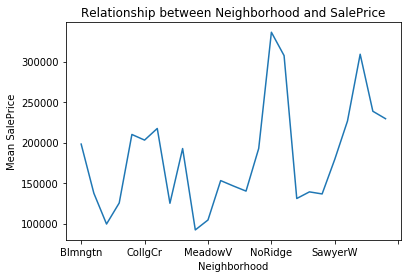

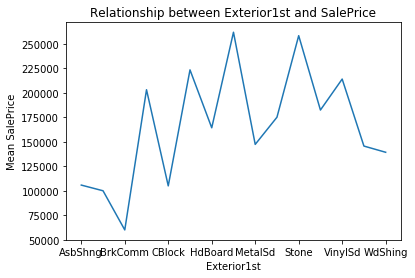

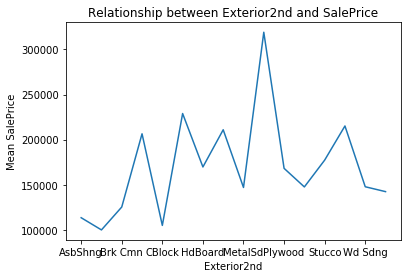

In [123]:
# let's explore the relationship of the categories with the target

for var in ['Neighborhood', 'Exterior1st', 'Exterior2nd']:
    fig = plt.figure()
    fig = x_train.groupby([var])['SalePrice'].mean().plot()
    fig.set_title(f'Relationship between {var} and SalePrice')
    fig.set_ylabel('Mean SalePrice')
    plt.show()

#### Ordered Integer Encoding with Pandas

In [124]:
# lets order the labels according to the mean target value
x_train.groupby(["Neighborhood"])["SalePrice"].mean().sort_values()

Neighborhood
IDOTRR      92174.166667
BrDale      99440.000000
MeadowV    104441.666667
Edwards    125082.676056
BrkSide    125438.414634
OldTown    130958.328767
Sawyer     136596.442623
Blueste    137500.000000
SWISU      139154.666667
NPkVill    140107.142857
NAmes      146435.264901
Mitchel    153070.444444
SawyerW    179463.088889
Gilbert    192662.290909
NWAmes     192788.235294
Blmngtn    198164.500000
CollgCr    203086.371429
ClearCr    210034.666667
Crawfor    217453.914286
Somerst    226644.196429
Veenker    229500.000000
Timber     238700.100000
NridgHt    307418.137255
StoneBr    309105.937500
NoRidge    336264.666667
Name: SalePrice, dtype: float64

In [125]:
# we then generate an ordered list with the labels
ordered_lables = x_train.groupby(["Neighborhood"])["SalePrice"].mean().sort_values().index
ordered_lables

Index(['IDOTRR', 'BrDale', 'MeadowV', 'Edwards', 'BrkSide', 'OldTown',
       'Sawyer', 'Blueste', 'SWISU', 'NPkVill', 'NAmes', 'Mitchel', 'SawyerW',
       'Gilbert', 'NWAmes', 'Blmngtn', 'CollgCr', 'ClearCr', 'Crawfor',
       'Somerst', 'Veenker', 'Timber', 'NridgHt', 'StoneBr', 'NoRidge'],
      dtype='object', name='Neighborhood')

In [126]:
# now we create a dictionary with above vals
ordinal_mapping = {
    k:v
    for v, k in enumerate(ordered_lables, 0)
}
ordinal_mapping

{'IDOTRR': 0,
 'BrDale': 1,
 'MeadowV': 2,
 'Edwards': 3,
 'BrkSide': 4,
 'OldTown': 5,
 'Sawyer': 6,
 'Blueste': 7,
 'SWISU': 8,
 'NPkVill': 9,
 'NAmes': 10,
 'Mitchel': 11,
 'SawyerW': 12,
 'Gilbert': 13,
 'NWAmes': 14,
 'Blmngtn': 15,
 'CollgCr': 16,
 'ClearCr': 17,
 'Crawfor': 18,
 'Somerst': 19,
 'Veenker': 20,
 'Timber': 21,
 'NridgHt': 22,
 'StoneBr': 23,
 'NoRidge': 24}

In [127]:
# now lets apply the mapping in train and test sets
x_train["Neighborhood"] = x_train["Neighborhood"].map(ordinal_mapping)
x_test["Neighborhood"] = x_test["Neighborhood"].map(ordinal_mapping)
x_train["Neighborhood"].head()

64      16
682     17
960      4
1384     3
1100     8
Name: Neighborhood, dtype: int64

In [128]:
x_train.head()

,Neighborhood,Exterior1st,Exterior2nd,SalePrice
64,16,VinylSd,VinylSd,219500
682,17,Wd Sdng,Wd Sdng,173000
960,4,Wd Sdng,Plywood,116500
1384,3,WdShing,Wd Shng,105000
1100,8,Wd Sdng,Wd Sdng,60000


In [129]:
# making the above step a function
def target_guided_encode(data, feature, target):
    _labels = data.groupby([feature])[target].mean().sort_values().index
    mapping = {
        k : v 
        for v, k in enumerate(_labels, 0)
    }
    data[feature] = data[feature].map(mapping)
    return data

In [130]:
# lets apply the above function for remaining variables
for feature in ["Exterior1st", "Exterior2nd"]:
    x_train = target_guided_encode(x_train, feature, "SalePrice")
    x_test = target_guided_encode(x_test, feature, "SalePrice")

In [131]:
x_train.head()

,Neighborhood,Exterior1st,Exterior2nd,SalePrice
64,16,11,13,219500
682,17,5,7,173000
960,4,5,8,116500
1384,3,4,4,105000
1100,8,5,7,60000


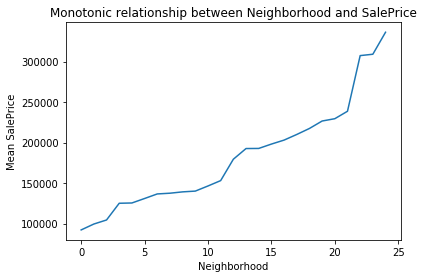

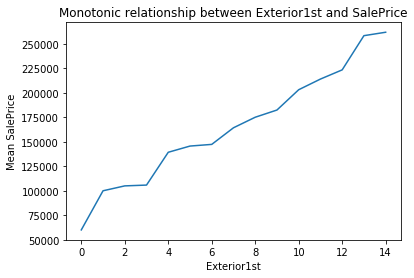

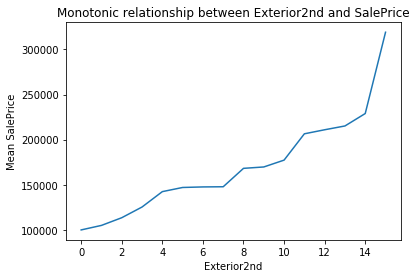

In [132]:
# now lets again inspect the behaviour of target wrt features
for var in ['Neighborhood', 'Exterior1st', 'Exterior2nd']:
    fig = plt.figure()
    fig = x_train.groupby([var])['SalePrice'].mean().plot()
    fig.set_title('Monotonic relationship between {} and SalePrice'.format(var))
    fig.set_ylabel('Mean SalePrice')
    plt.show()

#### Ordered Integer encoding with Feature Engine

In [133]:
# let's separate into training and testing set

x_train, x_test, y_train, y_test = train_test_split(
    data[['Neighborhood', 'Exterior1st', 'Exterior2nd']], # predictors
    data['SalePrice'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

x_train.shape, x_test.shape

((1022, 3), (438, 3))

In [135]:
ordinal_encoder = OrdinalCategoricalEncoder(
    # here we indicate the encoding method
    encoding_method="ordered",
    variables=['Neighborhood', 'Exterior1st', 'Exterior2nd'],
)
ordinal_encoder.fit(X=x_train, y=y_train)

OrdinalCategoricalEncoder(variables=['Neighborhood', 'Exterior1st',
                                     'Exterior2nd'])

In [136]:
ordinal_encoder.encoder_dict_

{'Neighborhood': {'IDOTRR': 0,
  'BrDale': 1,
  'MeadowV': 2,
  'Edwards': 3,
  'BrkSide': 4,
  'OldTown': 5,
  'Sawyer': 6,
  'Blueste': 7,
  'SWISU': 8,
  'NPkVill': 9,
  'NAmes': 10,
  'Mitchel': 11,
  'SawyerW': 12,
  'Gilbert': 13,
  'NWAmes': 14,
  'Blmngtn': 15,
  'CollgCr': 16,
  'ClearCr': 17,
  'Crawfor': 18,
  'Somerst': 19,
  'Veenker': 20,
  'Timber': 21,
  'NridgHt': 22,
  'StoneBr': 23,
  'NoRidge': 24},
 'Exterior1st': {'BrkComm': 0,
  'AsphShn': 1,
  'CBlock': 2,
  'AsbShng': 3,
  'WdShing': 4,
  'Wd Sdng': 5,
  'MetalSd': 6,
  'HdBoard': 7,
  'Plywood': 8,
  'Stucco': 9,
  'BrkFace': 10,
  'VinylSd': 11,
  'CemntBd': 12,
  'Stone': 13,
  'ImStucc': 14},
 'Exterior2nd': {'AsphShn': 0,
  'CBlock': 1,
  'AsbShng': 2,
  'Brk Cmn': 3,
  'Wd Shng': 4,
  'MetalSd': 5,
  'Stone': 6,
  'Wd Sdng': 7,
  'Plywood': 8,
  'HdBoard': 9,
  'Stucco': 10,
  'BrkFace': 11,
  'ImStucc': 12,
  'VinylSd': 13,
  'CmentBd': 14,
  'Other': 15}}

In [137]:
ordinal_encoder.variables

['Neighborhood', 'Exterior1st', 'Exterior2nd']

In [138]:
# now lets apply transformation
x_train = ordinal_encoder.transform(x_train)
x_test = ordinal_encoder.transform(x_test)
x_train.head()

,Neighborhood,Exterior1st,Exterior2nd
64,16,11,13
682,17,5,7
960,4,5,8
1384,3,4,4
1100,8,5,7


### Mean Encoding 

<b> Advantages of target guided encodings:</b>

- Captures information within the category, therefore creating more predictive features
- Creates a monotonic relationship between the variable and the target, therefore suitable for linear models
- Do not expand the feature space


<b> Limitations:</b>

- Prone to cause over-fitting
- Difficult to cross-validate with current libraries

In [5]:
data = pd.read_csv(
    'data/titanic.csv',
    usecols=['cabin', 'sex', 'embarked', 'survived'])

data.head()

,survived,sex,cabin,embarked
0,1,female,B,S
1,1,male,C,S
2,0,female,C,S
3,0,male,C,S
4,0,female,C,S


In [7]:
# lets fill all the missing values
data["embarked"] = data["embarked"].fillna("MISSING")

In [8]:
# print out the unique categories
[print(f"{col} : {len(data[col].unique())}") for col in data.columns]

survived : 2
sex : 2
cabin : 9
embarked : 4


[None, None, None, None]

In [9]:
# let's separate into training and testing set
x_train, x_test, y_train, y_test = train_test_split(
    data[['cabin', 'sex', 'embarked', 'survived']], # keep the target
    data['survived'],
    test_size=0.3, 
    random_state=0) 

x_train.shape, x_test.shape

((916, 4), (393, 4))

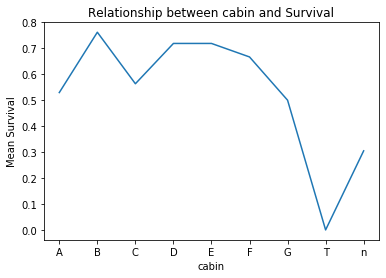

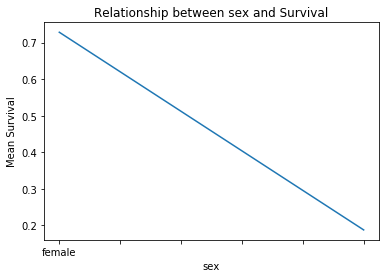

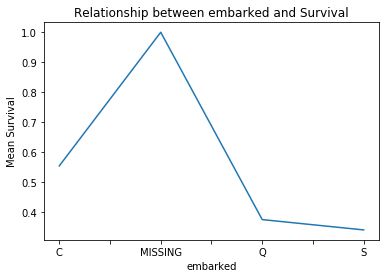

In [10]:
# let's explore the relationship of the categories with the target
for var in ['cabin', 'sex', 'embarked']:
    fig = plt.figure()
    fig = x_train.groupby([var])['survived'].mean().plot()
    fig.set_title('Relationship between {} and Survival'.format(var))
    fig.set_ylabel('Mean Survival')
    plt.show()

#### Mean Encoding with Pandas

In [11]:
# let's make ordered lables mapping
ordered_labels = x_train.groupby(["cabin"])["survived"].mean().to_dict()
ordered_labels

{'A': 0.5294117647058824,
 'B': 0.7619047619047619,
 'C': 0.5633802816901409,
 'D': 0.71875,
 'E': 0.71875,
 'F': 0.6666666666666666,
 'G': 0.5,
 'T': 0.0,
 'n': 0.30484330484330485}

In [12]:
# we now propogate that to train and test sets
x_train["cabin"] = x_train["cabin"].map(ordered_labels)
x_test["cabin"] = x_test["cabin"].map(ordered_labels)
x_train.head()

,cabin,sex,embarked,survived
501,0.304843,female,S,1
588,0.304843,female,S,1
402,0.304843,female,C,1
1193,0.304843,male,Q,0
686,0.304843,female,Q,1


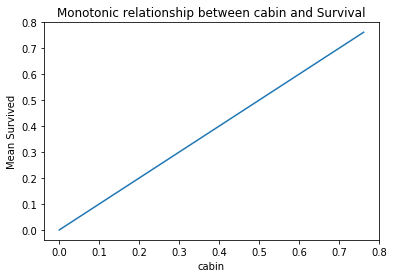

In [13]:
# now we observe a monotonic relation
for var in ['cabin']:
    fig = plt.figure()
    fig = x_train.groupby([var])['survived'].mean().plot()
    fig.set_title(f'Monotonic relationship between {var} and Survival')
    fig.set_ylabel('Mean Survived')
    plt.show()

#### Mean Encoding with Feature Engine

In [14]:
from feature_engine.categorical_encoders import MeanCategoricalEncoder

In [15]:
mean_encoder = MeanCategoricalEncoder(
    variables=["sex", "embarked"]
)
mean_encoder.fit(x_train, y_train)

MeanCategoricalEncoder(variables=['sex', 'embarked'])

In [16]:
x_train = mean_encoder.transform(x_train)
x_test = mean_encoder.transform(x_test)
x_train.head()

,cabin,sex,embarked,survived
501,0.304843,0.728358,0.338957,1
588,0.304843,0.728358,0.338957,1
402,0.304843,0.728358,0.553073,1
1193,0.304843,0.187608,0.373494,0
686,0.304843,0.728358,0.373494,1


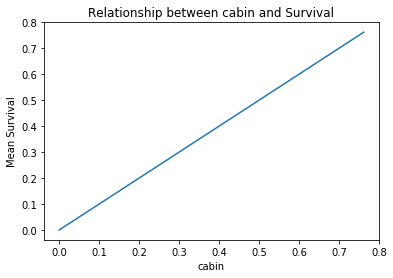

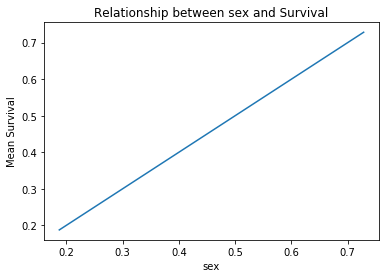

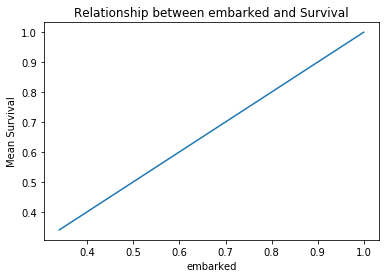

In [17]:
# let's explore the relationship of the categories with the target
for var in ['cabin', 'sex', 'embarked']:
    fig = plt.figure()
    fig = x_train.groupby([var])['survived'].mean().plot()
    fig.set_title(f'Relationship between {var} and Survival')
    fig.set_ylabel('Mean Survival')
    plt.show()

### Probability Ratio Encodings

These encoding is suitable for classification problems only, where the target is binary.

For each category, we calculate the mean of target=1, that is the probability of the target being 1 ( P(1) ), and the probability of the target=0 ( P(0) ). And then, we calculate the ratio P(1)/P(0), and replace the categories by that ratio.

In [19]:
# for encoding with feature-engine
from feature_engine.categorical_encoders import WoERatioCategoricalEncoder

data = pd.read_csv(
    'data/titanic.csv',
    usecols=['cabin', 'sex', 'embarked', 'survived'])

data.head()

,survived,sex,cabin,embarked
0,1,female,B,S
1,1,male,C,S
2,0,female,C,S
3,0,male,C,S
4,0,female,C,S


In [20]:
# dropping na's

data = data.dropna(subset=["embarked"])
data.shape

(1307, 4)

In [22]:
# drop the cabin T as there are very few observations
data = data[data["cabin"] != "T"]
data.shape

(1306, 4)

In [23]:
# let's see the unique labels
[print(f"{col} : {len(data[col].unique())} labels") for col in data.columns]

survived : 2 labels
sex : 2 labels
cabin : 8 labels
embarked : 3 labels


[None, None, None, None]

In [49]:
# split
x_train, x_test, y_train, y_test = train_test_split(
    data[['sex', 'embarked', 'cabin', 'survived']],  # also keep target
    data['survived'],  # target
    test_size=0.3,  
    random_state=0) 

x_train.shape, x_test.shape

((914, 4), (392, 4))

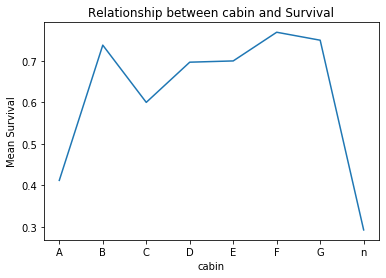

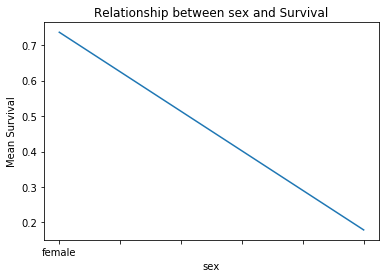

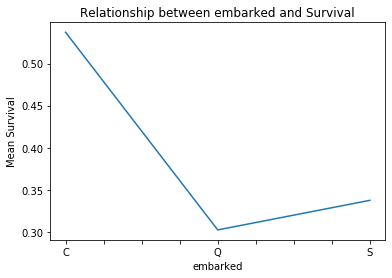

In [44]:
# explore the relationship of the categories with the target
for var in ['cabin', 'sex', 'embarked']:
    fig = plt.figure()
    fig = x_train.groupby([var])['survived'].mean().plot()
    fig.set_title(f'Relationship between {var} and Survival')
    fig.set_ylabel('Mean Survival')
    plt.show()

#### Probability ratio encoding with pandas

In [50]:
# calculating the probability of the survived=1 per cabin category
prob_df = x_train.groupby(["cabin"])["survived"].mean()

# making the above a df
prob_df = pd.DataFrame(prob_df)
prob_df

,survived
cabin,
A,0.411765
B,0.738095
C,0.600000
D,0.696970
E,0.700000
F,0.769231
G,0.750000
n,0.292199


In [51]:
# lets make a probability for survived=0 or died=1
prob_df["died"] = 1 - prob_df["survived"]
prob_df

,survived,died
cabin,,
A,0.411765,0.588235
B,0.738095,0.261905
C,0.600000,0.400000
D,0.696970,0.303030
E,0.700000,0.300000
F,0.769231,0.230769
G,0.750000,0.250000
n,0.292199,0.707801


In [52]:
# FOR SANITY CHECK CREATING TOTAL which should be equal to 1
prob_df["__total"] = prob_df["survived"] + prob_df["died"]
prob_df

,survived,died,__total
cabin,,,
A,0.411765,0.588235,1.0
B,0.738095,0.261905,1.0
C,0.600000,0.400000,1.0
D,0.696970,0.303030,1.0
E,0.700000,0.300000,1.0
F,0.769231,0.230769,1.0
G,0.750000,0.250000,1.0
n,0.292199,0.707801,1.0


In [53]:
# now let's calculate the ratio of p(1)/p(0)

prob_df["ratio"] = prob_df["survived"] / prob_df["died"]
prob_df

,survived,died,__total,ratio
cabin,,,,
A,0.411765,0.588235,1.0,0.700000
B,0.738095,0.261905,1.0,2.818182
C,0.600000,0.400000,1.0,1.500000
D,0.696970,0.303030,1.0,2.300000
E,0.700000,0.300000,1.0,2.333333
F,0.769231,0.230769,1.0,3.333333
G,0.750000,0.250000,1.0,3.000000
n,0.292199,0.707801,1.0,0.412826


In [54]:
# now that we have the ratios let's get the mappings
mappings = prob_df["ratio"].to_dict()
mappings

{'A': 0.7,
 'B': 2.818181818181819,
 'C': 1.4999999999999998,
 'D': 2.3000000000000007,
 'E': 2.333333333333333,
 'F': 3.333333333333334,
 'G': 3.0,
 'n': 0.4128256513026052}

In [55]:
# applying to train and test
x_train["cabin"] = x_train["cabin"].map(mappings)
x_test["cabin"] = x_test["cabin"].map(mappings)

In [56]:
x_train.head(10)

,sex,embarked,cabin,survived
843,male,S,0.412826,0
869,male,S,0.412826,0
430,female,S,0.412826,1
481,female,C,0.412826,1
1308,male,S,0.412826,0
456,female,S,0.412826,0
118,male,S,2.300000,0
485,male,C,2.300000,0
297,female,C,0.412826,1
263,female,S,2.333333,1


In [57]:
# functionalizing the prob ratio

def probability_ratio_encode(data, feature, target):
    __probability = pd.DataFrame(data.groupby(feature)[target].mean())
    __probability["negative"] = 1 - __probability[target]
    __probability["ratio"] = __probability[target] / __probability["negative"]
    
    # masking
    data[feature] = data[feature].map(__probability["ratio"].to_dict())
    return data

In [58]:
for feature in ["sex", "embarked"]:
    x_train = probability_ratio_encode(x_train, feature, "survived")
x_train.head()

,sex,embarked,cabin,survived
843,0.218107,0.509434,0.412826,0
869,0.218107,0.509434,0.412826,0
430,2.788235,0.509434,0.412826,1
481,2.788235,1.160920,0.412826,1
1308,0.218107,0.509434,0.412826,0


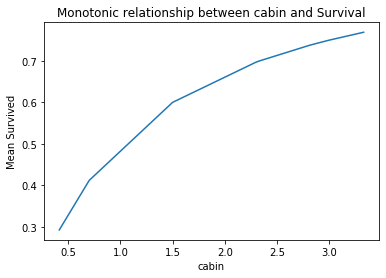

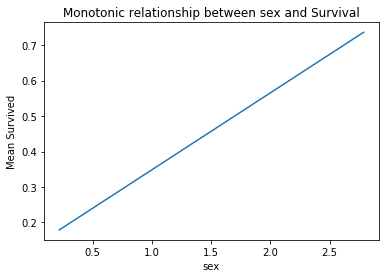

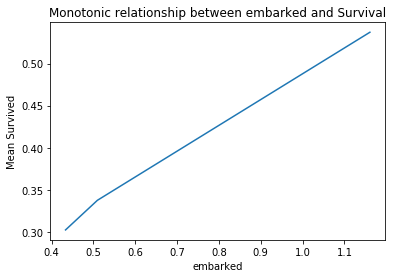

In [59]:
# let's inspect the newly created monotonic relationship
# between the categorical variables and the target
for var in ['cabin', 'sex', 'embarked']:
    fig = plt.figure()
    fig = x_train.groupby([var])['survived'].mean().plot()
    fig.set_title('Monotonic relationship between {} and Survival'.format(var))
    fig.set_ylabel('Mean Survived')
    plt.show()

#### Probability ratio encoding with feature engine

In [65]:
# split
x_train, x_test, y_train, y_test = train_test_split(
    data[['sex', 'embarked', 'cabin']],
    data['survived'],  # target
    test_size=0.3,  
    random_state=0) 

x_train.shape, x_test.shape
# -----

((914, 3), (392, 3))

In [66]:
ratio_encoder = WoERatioCategoricalEncoder(
    encoding_method="ratio",
    variables=["cabin", "sex", "embarked"]
)
ratio_encoder.fit(x_train, y_train)


WoERatioCategoricalEncoder(encoding_method='ratio',
                           variables=['cabin', 'sex', 'embarked'])

In [67]:
ratio_encoder.encoder_dict_

{'cabin': {'A': 0.7,
  'B': 2.818181818181819,
  'C': 1.4999999999999998,
  'D': 2.3000000000000007,
  'E': 2.333333333333333,
  'F': 3.333333333333334,
  'G': 3.0,
  'n': 0.4128256513026052},
 'sex': {'female': 2.788235294117647, 'male': 0.21810699588477367},
 'embarked': {'C': 1.160919540229885,
  'Q': 0.4333333333333333,
  'S': 0.5094339622641509}}

In [68]:
# transform
x_train = ratio_encoder.transform(x_train)
x_test = ratio_encoder.transform(x_test)
x_test.head()

,sex,embarked,cabin
612,2.788235,0.509434,0.412826
415,2.788235,0.509434,0.412826
531,0.218107,1.160920,0.412826
1150,0.218107,0.509434,0.412826
945,0.218107,0.509434,0.412826
